In [1]:
import torch

In [2]:
# load mask and load detectron and do inference on an image

In [3]:
import cv2

In [4]:
import os

In [5]:
print(os.getcwd())

/home/locobotm


In [6]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [7]:
model = get_instance_segmentation_model(2)

In [8]:
# model.load_state_dict(torch.load('/home/locobotm/Downloads/maskrcnn_chairs_1.pt'))

In [9]:
torch.cuda.device_count()

2

In [10]:
device = torch.device("cuda:0")

In [11]:
torch.cuda.device_count()

2

In [12]:
torch.cuda.is_available()

True

# Defining the Dataset

In [13]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
from cv2 import imshow

class LocobotDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images2"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "chair_masks2"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "images2", self.imgs[idx])
        mask_path = os.path.join(self.root, "chair_masks2", self.masks[idx])
        # print(mask_path)
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # print('obj_ids {}'.format(obj_ids))
        # cv2_imshow(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [14]:
os.getcwd()
import sys
sys.path.append('/home/locobotm/vision/references/detection/')

In [15]:
root = '/home/locobotm/data'
dataset = LocobotDataset(root)

In [16]:
dataset

In [17]:
from vision.references.detection.engine import train_one_epoch, evaluate
import utils
import vision.references.detection.transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [18]:
dataset = LocobotDataset(root, get_transform(train=True))
print("len(dataset) = {}".format(len(dataset)))
dataset_test = LocobotDataset(root, get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
print(indices[:-10])
print(indices[-10:])
dataset = torch.utils.data.Subset(dataset, indices[:-10])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-10:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

len(dataset) = 83
[1, 68, 74, 11, 45, 6, 55, 44, 67, 43, 70, 0, 33, 46, 36, 63, 59, 38, 60, 39, 7, 66, 9, 27, 20, 22, 4, 71, 82, 12, 29, 31, 77, 14, 23, 3, 73, 47, 40, 49, 2, 10, 56, 21, 37, 76, 79, 80, 54, 61, 42, 35, 52, 53, 16, 62, 41, 81, 50, 48, 24, 78, 5, 57, 32, 51, 75, 58, 25, 64, 19, 28, 69]
[65, 15, 30, 17, 18, 34, 26, 72, 13, 8]


In [19]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [20]:
# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/37]  eta: 0:02:30  lr: 0.000144  loss: 3.6939 (3.6939)  loss_classifier: 0.4896 (0.4896)  loss_box_reg: 0.1996 (0.1996)  loss_mask: 2.8989 (2.8989)  loss_objectness: 0.0760 (0.0760)  loss_rpn_box_reg: 0.0297 (0.0297)  time: 4.0739  data: 0.7753  max mem: 2145
Epoch: [0]  [10/37]  eta: 0:00:19  lr: 0.001531  loss: 2.2506 (2.4899)  loss_classifier: 0.4104 (0.3725)  loss_box_reg: 0.1996 (0.2101)  loss_mask: 1.5116 (1.8414)  loss_objectness: 0.0325 (0.0454)  loss_rpn_box_reg: 0.0205 (0.0206)  time: 0.7093  data: 0.0788  max mem: 2422
Epoch: [0]  [20/37]  eta: 0:00:08  lr: 0.002919  loss: 1.1890 (1.7899)  loss_classifier: 0.2368 (0.2926)  loss_box_reg: 0.1629 (0.1891)  loss_mask: 0.6331 (1.2333)  loss_objectness: 0.0465 (0.0549)  loss_rpn_box_reg: 0.0130 (0.0201)  time: 0.3455  data: 0.0074  max mem: 2422
Epoch: [0]  [30/37]  eta: 0:00:03  lr: 0.004306  loss: 0.9425 (1.5142)  loss_classifier: 0.1711 (0.2600)  loss_box_reg: 0.1382 (0.1844)  loss_mask: 0.5148 (0.9920)  loss_ob

Epoch: [2]  [20/37]  eta: 0:00:05  lr: 0.005000  loss: 0.5465 (0.5597)  loss_classifier: 0.1229 (0.1172)  loss_box_reg: 0.0810 (0.0857)  loss_mask: 0.3145 (0.3220)  loss_objectness: 0.0135 (0.0208)  loss_rpn_box_reg: 0.0114 (0.0140)  time: 0.3235  data: 0.0046  max mem: 2531
Epoch: [2]  [30/37]  eta: 0:00:02  lr: 0.005000  loss: 0.5448 (0.5673)  loss_classifier: 0.1212 (0.1282)  loss_box_reg: 0.0692 (0.0918)  loss_mask: 0.2869 (0.3155)  loss_objectness: 0.0103 (0.0171)  loss_rpn_box_reg: 0.0135 (0.0146)  time: 0.3269  data: 0.0053  max mem: 2620
Epoch: [2]  [36/37]  eta: 0:00:00  lr: 0.005000  loss: 0.5537 (0.5703)  loss_classifier: 0.1382 (0.1325)  loss_box_reg: 0.0810 (0.0910)  loss_mask: 0.3119 (0.3154)  loss_objectness: 0.0066 (0.0161)  loss_rpn_box_reg: 0.0152 (0.0152)  time: 0.3240  data: 0.0052  max mem: 2620
Epoch: [2] Total time: 0:00:12 (0.3291 s / it)
creating index...
index created!
Test:  [ 0/10]  eta: 0:00:01  model_time: 0.0828 (0.0828)  evaluator_time: 0.0229 (0.0229)  

Epoch: [4]  [36/37]  eta: 0:00:00  lr: 0.000500  loss: 0.4149 (0.4313)  loss_classifier: 0.0997 (0.0992)  loss_box_reg: 0.0468 (0.0587)  loss_mask: 0.2557 (0.2532)  loss_objectness: 0.0074 (0.0077)  loss_rpn_box_reg: 0.0089 (0.0125)  time: 0.3255  data: 0.0051  max mem: 2738
Epoch: [4] Total time: 0:00:12 (0.3337 s / it)
creating index...
index created!
Test:  [ 0/10]  eta: 0:00:01  model_time: 0.0718 (0.0718)  evaluator_time: 0.0114 (0.0114)  time: 0.1768  data: 0.0920  max mem: 2738
Test:  [ 9/10]  eta: 0:00:00  model_time: 0.0718 (0.0737)  evaluator_time: 0.0149 (0.0145)  time: 0.1003  data: 0.0110  max mem: 2738
Test: Total time: 0:00:01 (0.1026 s / it)
Averaged stats: model_time: 0.0718 (0.0737)  evaluator_time: 0.0149 (0.0145)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.307
 Average Precision  (AP) @[ IoU=0.50      | area=   all | 

Test:  [ 9/10]  eta: 0:00:00  model_time: 0.0723 (0.0741)  evaluator_time: 0.0151 (0.0144)  time: 0.1013  data: 0.0117  max mem: 2744
Test: Total time: 0:00:01 (0.1037 s / it)
Averaged stats: model_time: 0.0723 (0.0741)  evaluator_time: 0.0151 (0.0144)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.324
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.567
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.319
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.551
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.237
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.428
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.196
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 1

Epoch: [9]  [ 0/37]  eta: 0:00:22  lr: 0.000005  loss: 0.4940 (0.4940)  loss_classifier: 0.1045 (0.1045)  loss_box_reg: 0.0694 (0.0694)  loss_mask: 0.3004 (0.3004)  loss_objectness: 0.0059 (0.0059)  loss_rpn_box_reg: 0.0139 (0.0139)  time: 0.6091  data: 0.2579  max mem: 2744
Epoch: [9]  [10/37]  eta: 0:00:09  lr: 0.000005  loss: 0.3446 (0.3459)  loss_classifier: 0.0732 (0.0756)  loss_box_reg: 0.0332 (0.0414)  loss_mask: 0.2260 (0.2132)  loss_objectness: 0.0051 (0.0053)  loss_rpn_box_reg: 0.0091 (0.0103)  time: 0.3610  data: 0.0266  max mem: 2744
Epoch: [9]  [20/37]  eta: 0:00:06  lr: 0.000005  loss: 0.3504 (0.3701)  loss_classifier: 0.0787 (0.0842)  loss_box_reg: 0.0473 (0.0474)  loss_mask: 0.2260 (0.2226)  loss_objectness: 0.0039 (0.0048)  loss_rpn_box_reg: 0.0091 (0.0111)  time: 0.3621  data: 0.0049  max mem: 2744
Epoch: [9]  [30/37]  eta: 0:00:02  lr: 0.000005  loss: 0.3798 (0.3686)  loss_classifier: 0.0809 (0.0842)  loss_box_reg: 0.0447 (0.0466)  loss_mask: 0.2250 (0.2220)  loss_ob

In [21]:
import colorsys
import random
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def apply_mask(image, mask, color, alpha=0.5):
  # mask is (480, 640), image (480, 640, 3)
  # image = np.asarray(image)
  mask = np.asarray(mask)
  # image.setflags(write=1)
  # print(image.shape, mask.shape)
  image_c = np.zeros(shape = image.shape)
  for c in range(3):
    image_c[:,:,c] = np.where(mask > 200, image[:,:,c] * (1-alpha) + alpha * color[c] * mask, image[:,:,c])

  return image_c


In [22]:
import IPython

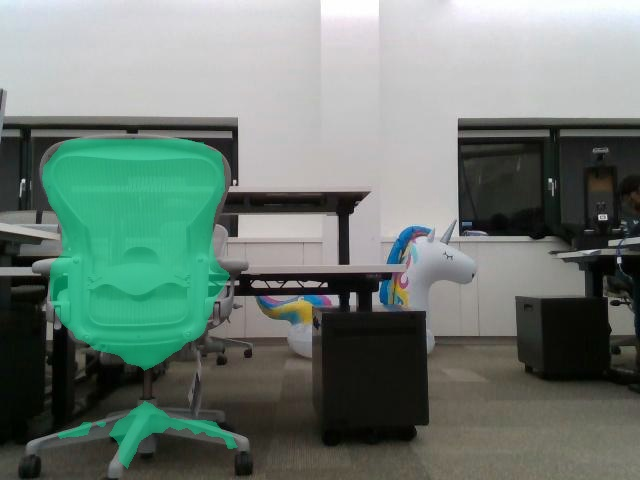

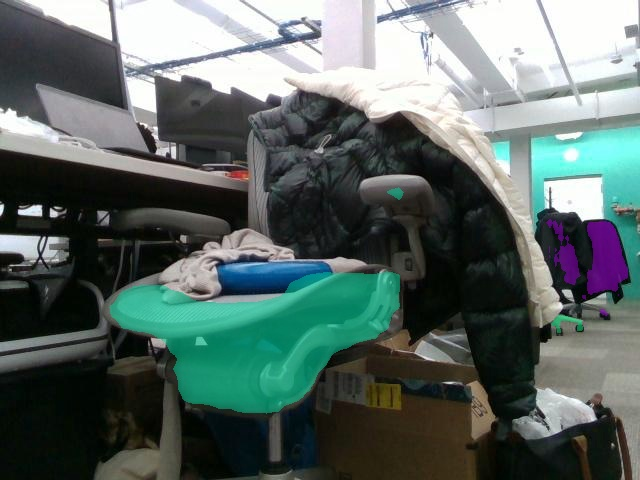

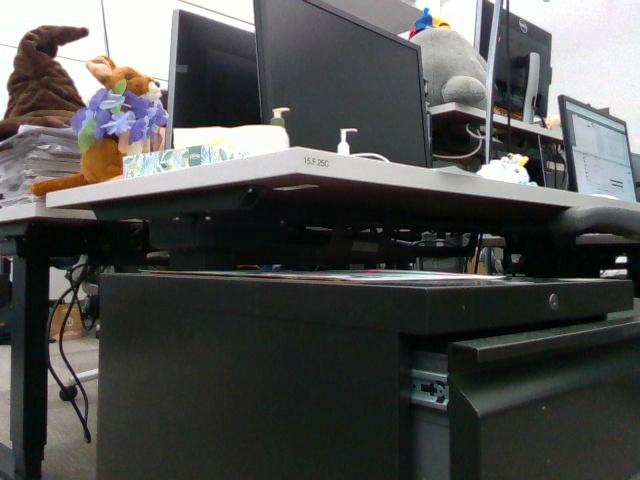

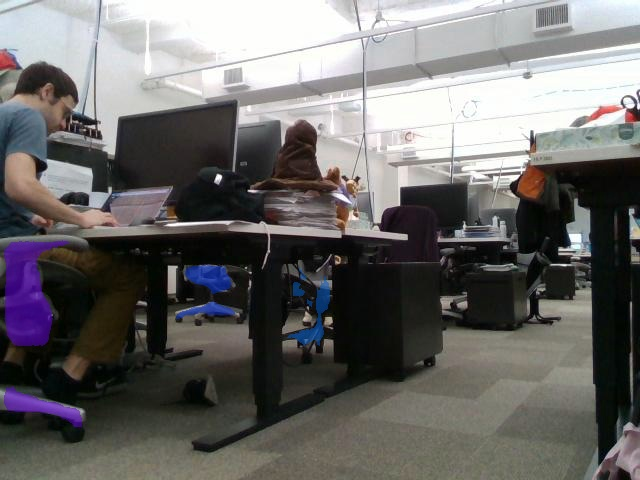

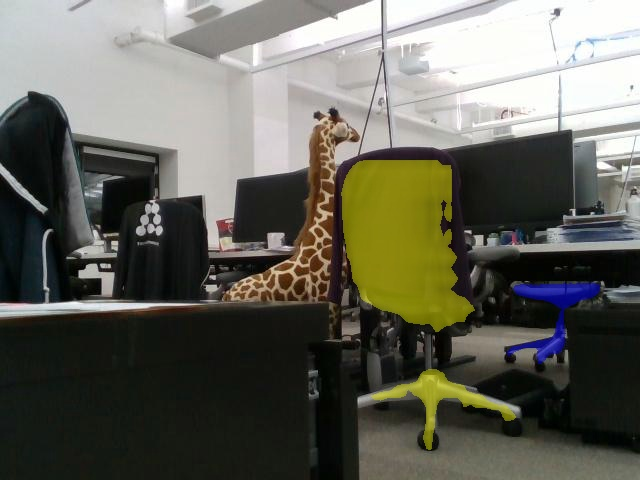

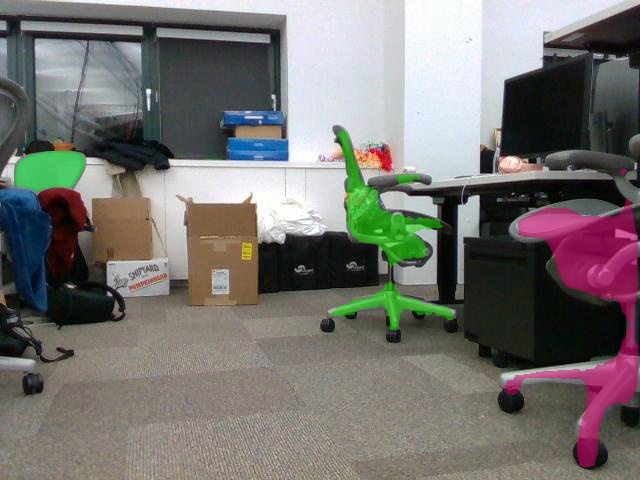

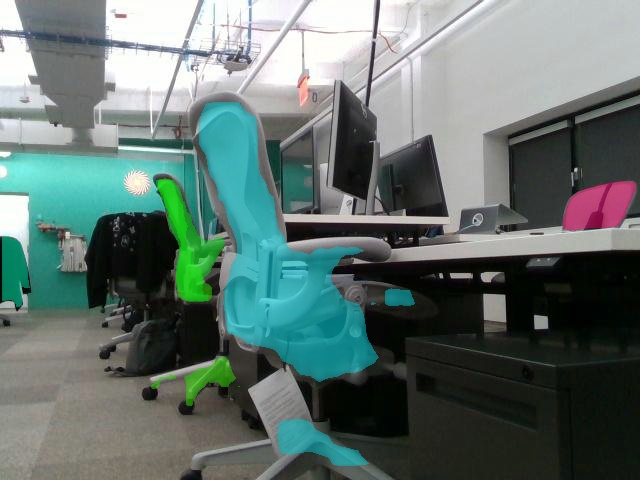

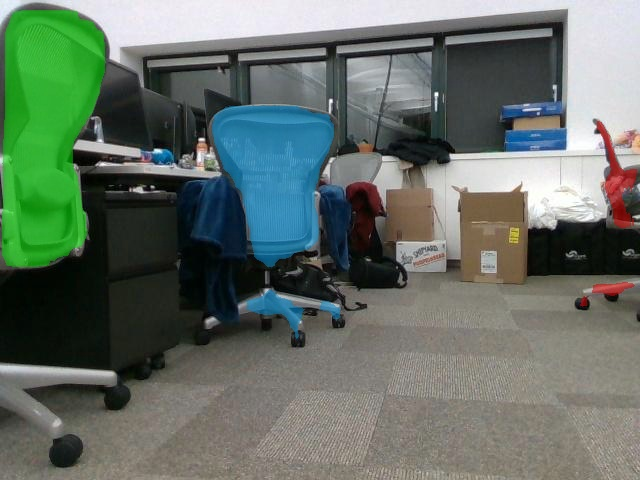

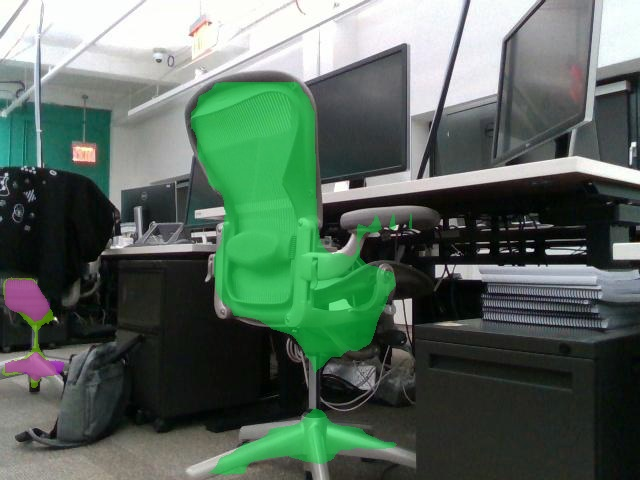

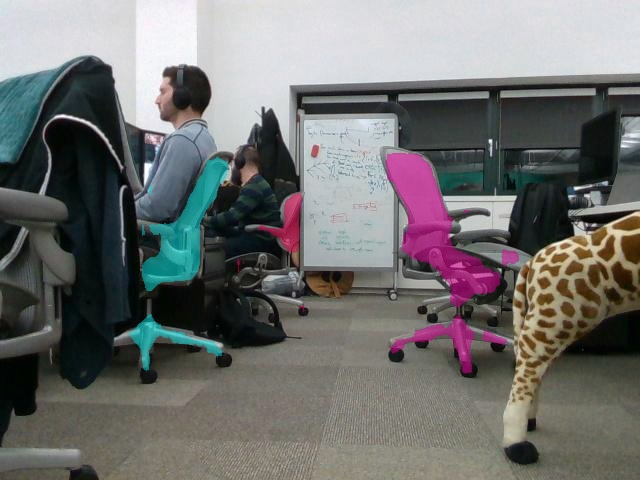

In [23]:

model.eval()
import matplotlib.pyplot as plt
for img, _ in dataset_test:
    with torch.no_grad():
        prediction = model([img.to(device)])
        orig = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
        # print(type(orig))
        # cv2_imshow(np.asarray(ori/g))  

        thresh = 0.8
        N = prediction[0]['boxes'].shape[0]

        colors = random_colors(N)

        masks = orig.copy() 
#         orig.show()
        masked_image = np.asarray(orig)
        # print("type {}, size {}, mode {}".format(type(masks), masks.size, masks.mode))
        for i in range(N):
            color = colors[i]
            if prediction[0]['scores'][i] > thresh:
              mask = Image.fromarray(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy())
              masked_image = apply_mask(masked_image, mask.copy(), color)
              # print("np type {}, size {}".format(type(mask_np), mask_np.shape))
              # print("type {}, size {} mode {}".format(type(mask), mask.size, mask.mode))
#               masks.paste(mask, (0,0), mask)
              # masks = Image.blend(mask, masks, 0.4)
            # masked_image = apply_mask(masked_image, prediction)
            
        _, ret = cv2.imencode('.jpg', masked_image)
        i = IPython.display.Image(data=ret)
        IPython.display.display(i)
#         img = Image.fromarray(masked_image, 'RGB')
#         cv2.imshow('masked' , img)
#         img.show()

#         masked_image.show()
#         cv2.imshow('masked', masked_image)
        #       plt.imshow(masked_image)
        #       plt.show()

In [24]:
# Save and load the model
torch.save(model.state_dict(), '/home/locobotm/model1.pt')

In [25]:
model_new = get_instance_segmentation_model(2)

In [26]:
model_new.load_state_dict(torch.load('/home/locobotm/model1.pt'))

<All keys matched successfully>

<class 'torch.Tensor'> torch.Size([3, 480, 640])
<class 'numpy.ndarray'>


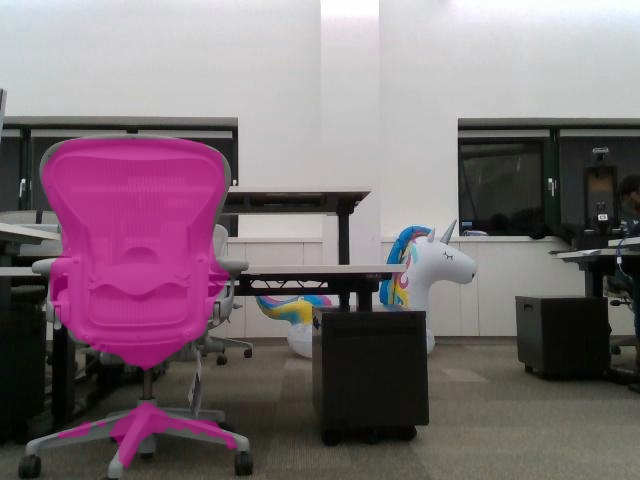

In [27]:
model_new.to(device)

model_new.eval()
import matplotlib.pyplot as plt
for img, _ in dataset_test:
    print(type(img), img.shape)
    with torch.no_grad():
        prediction = model_new([img.to(device)])
        orig = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
        # print(type(orig))
        # cv2_imshow(np.asarray(ori/g))  

        thresh = 0.8
        N = prediction[0]['boxes'].shape[0]

        colors = random_colors(N)

        masks = orig.copy() 
#         orig.show()
        masked_image = np.asarray(orig)
        # print("type {}, size {}, mode {}".format(type(masks), masks.size, masks.mode))
        for i in range(N):
            color = colors[i]
            if prediction[0]['scores'][i] > thresh:
              mask = Image.fromarray(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy())
              masked_image = apply_mask(masked_image, mask.copy(), color)
              # print("np type {}, size {}".format(type(mask_np), mask_np.shape))
              # print("type {}, size {} mode {}".format(type(mask), mask.size, mask.mode))
#               masks.paste(mask, (0,0), mask)
              # masks = Image.blend(mask, masks, 0.4)
            # masked_image = apply_mask(masked_image, prediction)
            
        _, ret = cv2.imencode('.jpg', masked_image)
        
        print(type(ret))
        i = IPython.display.Image(data=ret)
        IPython.display.display(i)
        break